In [1]:
import sys
import os

# Adjust path to your project root (modify if needed)
project_root = os.path.abspath("..")  # or "." if you're already in IR-Project
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:

from sqlalchemy.orm import Session
from database import SessionLocal
from repositories import query_repo, qrels_repo, search_result_repo
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Metrics
def precision_at_k(ranked_docs, relevant_docs, k):
    return len(set(ranked_docs[:k]) & set(relevant_docs)) / k

def recall_at_k(ranked_docs, relevant_docs, k):
    return len(set(ranked_docs[:k]) & set(relevant_docs)) / len(relevant_docs) if relevant_docs else 0

def average_precision(ranked_docs, relevant_docs):
    hits = 0
    sum_precisions = 0.0
    for i, doc_id in enumerate(ranked_docs):
        if doc_id in relevant_docs:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / len(relevant_docs) if relevant_docs else 0

def ndcg_at_k(ranked_docs, relevant_docs, k):
    def dcg(rel):
        return sum((2**r - 1) / np.log2(i + 2) for i, r in enumerate(rel))
    rel = [1 if doc_id in relevant_docs else 0 for doc_id in ranked_docs[:k]]
    ideal_rel = sorted(rel, reverse=True)
    return dcg(rel) / (dcg(ideal_rel) + 1e-10)

db: Session = SessionLocal()
qrels = defaultdict(set)
for qrel in qrels_repo.get_qrels_by_source(db,"beir/quora/dev"):
    qrels[qrel.query_id].add(qrel.doc_id)
print(f"✅ Loaded {len(qrels)} qrels")


✅ Loaded 5000 qrels


## 🔎 Evaluation for **VSM**

In [3]:

# --- VSM Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "vsm_index", "beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["VSM"]).T


,VSM
MAP,0.7018
Precision@10,0.1136
Recall@10,0.8434
NDCG@10,0.7732


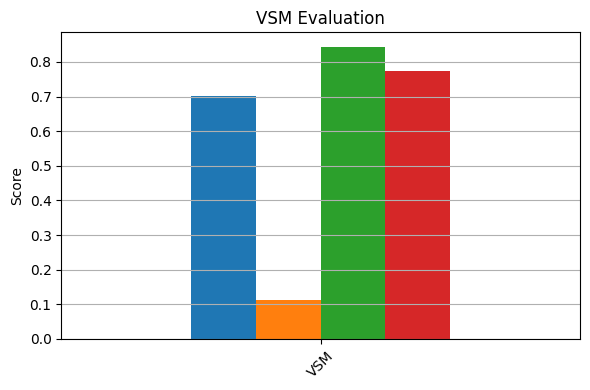

In [4]:

# Plot for VSM
pd.DataFrame(metrics, index=["VSM"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="VSM Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 🔎 Evaluation for **WORD2VEC**


In [5]:

# --- WORD2VEC Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "word2vec_plain","beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["WORD2VEC"]).T


,WORD2VEC
MAP,0.4874
Precision@10,0.0802
Recall@10,0.6174
NDCG@10,0.5602


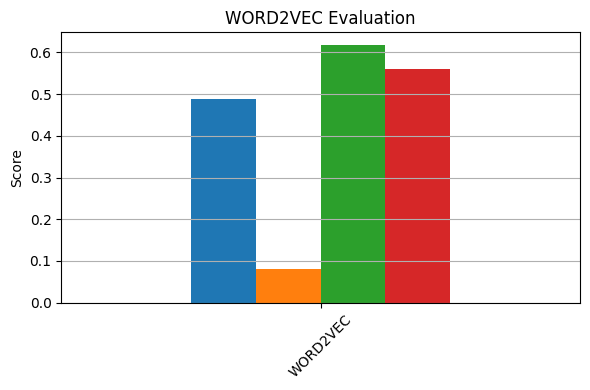

In [6]:

# Plot for WORD2VEC
pd.DataFrame(metrics, index=["WORD2VEC"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="WORD2VEC Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 🔎 Evaluation for **WORD2VEC with  Faiss**

In [7]:

# --- WORD2VEC Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "word2vec_faiss","beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["WORD2VEC Faiss"]).T


,WORD2VEC Faiss
MAP,0.3930
Precision@10,0.0713
Recall@10,0.5496
NDCG@10,0.4670


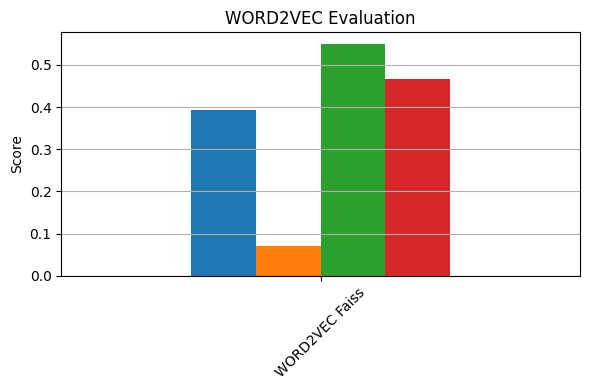

In [8]:

# Plot for WORD2VEC
pd.DataFrame(metrics, index=["WORD2VEC Faiss"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="WORD2VEC Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 🔎 Evaluation for **BM25**

In [9]:

# --- BM25 Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "bm25","beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["BM25"]).T


,BM25
MAP,0.7196
Precision@10,0.1165
Recall@10,0.8694
NDCG@10,0.7914


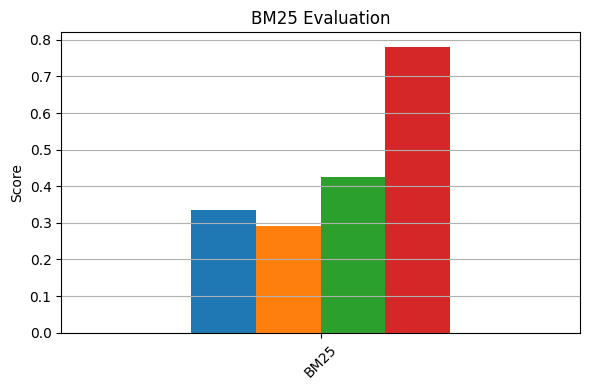

In [11]:

# Plot for BM25
pd.DataFrame(metrics, index=["BM25"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="BM25 Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 🔎 Evaluation for **HYBRID**

In [10]:

# --- HYBRID Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "hybrid_plain", "beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["HYBRID"]).T


,HYBRID
MAP,0.7225
Precision@10,0.1171
Recall@10,0.8697
NDCG@10,0.7951


In [ ]:

# Plot for HYBRID
pd.DataFrame(metrics, index=["HYBRID"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="HYBRID Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 🔎 Evaluation for **HYBRID Faiss**

In [11]:

# --- HYBRID Evaluation ---
k = 10
results = search_result_repo.get_results_by_algorithm(db, "hybrid_faiss", "beir/quora/dev")
ranked_by_query = defaultdict(list)
for r in results:
    ranked_by_query[r.query_id].append((r.doc_id, r.score))

# Sort
for qid in ranked_by_query:
    ranked_by_query[qid].sort(key=lambda x: -x[1])
    ranked_by_query[qid] = [doc_id for doc_id, _ in ranked_by_query[qid]]

map_scores, p_at_k, r_at_k, ndcg_scores = [], [], [], []
for qid, rel_docs in qrels.items():
    ranked = ranked_by_query.get(qid, [])
    if not ranked:
        continue
    map_scores.append(average_precision(ranked, rel_docs))
    p_at_k.append(precision_at_k(ranked, rel_docs, k))
    r_at_k.append(recall_at_k(ranked, rel_docs, k))
    ndcg_scores.append(ndcg_at_k(ranked, rel_docs, k))

metrics = {
    "MAP": round(np.mean(map_scores), 4),
    "Precision@10": round(np.mean(p_at_k), 4),
    "Recall@10": round(np.mean(r_at_k), 4),
    "NDCG@10": round(np.mean(ndcg_scores), 4),
}
pd.DataFrame(metrics, index=["HYBRID Faiss"]).T


,HYBRID Faiss
MAP,0.2313
Precision@10,0.0772
Recall@10,0.6430
NDCG@10,0.3680


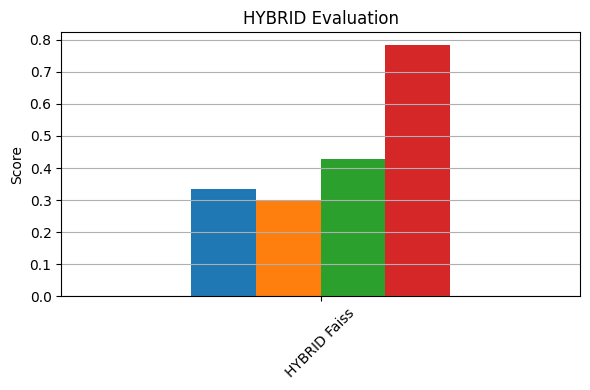

In [ ]:

# Plot for HYBRID
pd.DataFrame(metrics, index=["HYBRID Faiss"]).plot(
    kind="bar", figsize=(6,4), legend=False, title="HYBRID Evaluation"
)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
